In [29]:
import os
import base64
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.runnables import RunnableLambda
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables import RunnableMap
from langchain.globals import set_debug

In [30]:
# Set OpenAI API Key
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

# Enable debugging (verbose)
set_debug(True)

In [31]:
# Step 1: Define the model output schema
class ImageInformation(BaseModel):
    """Information about an image."""
    image_description: str = Field(description="A short description of the image")
    people_count: int = Field(description="Number of humans in the picture")
    main_objects: list[str] = Field(description="List of the main objects in the picture")
    main_character: str = Field(description="the main Character in the picture")
    outfit_characteristics: list[str] = Field(description="Characteristic of Outfit wore by main character")
    background_aesthetics: list[str] = Field(description="A list of characteristics of background of the main character")
    music_genre: list[str] = Field(description="A list of musical genre the photo belongs")


In [32]:
# Step 2: Define the parser
parser = JsonOutputParser(pydantic_object=ImageInformation)

In [33]:
# Step 3: Define a function to load and encode image
def load_image(inputs: dict) -> dict:
    """Load image from file and encode it as base64."""
    image_path = inputs["image_path"]
    with open(image_path, "rb") as image_file:
        image_base64 = base64.b64encode(image_file.read()).decode('utf-8')
    return {"image": image_base64, "prompt": inputs["prompt"]}

load_image_chain = RunnableLambda(load_image)

In [34]:

# Step 4: Define the image model interaction
def image_model(inputs: dict) -> dict:
    """Invoke GPT-4 Vision with image and prompt."""
    model = ChatOpenAI(model="o4-mini-2025-04-16", max_tokens=1024)
    message = model.invoke([
        HumanMessage(content=[
            {"type": "text", "text": inputs["prompt"]},
            {"type": "text", "text": parser.get_format_instructions()},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{inputs['image']}"}}
        ])
    ])
    return message.content

In [35]:
image_model_chain = RunnableLambda(image_model)

# Step 5: Define the complete vision chain
vision_chain = load_image_chain | image_model_chain | parser

In [36]:
vision_prompt = '''
You are a helpful AI vision model specializing in analyzing images of outfits and predicting the musical style or vibe associated with the outfit aesthetics. Your goal is to extract clear, structured details about the image that can later be used to find playlists on music platforms like Spotify or YouTube Music.

Instructions:
- Always analyze the outfit and environment carefully.
- Extract fashion-related features like outfit style, color schemes, texture, and overall aesthetic.
- Predict suitable music genres based on the outfit's vibe (e.g., hip-hop, indie rock, classical, synthwave).
- Stay objective and descriptive — avoid speculation if image information is unclear.
- Focus only on observable traits; do not suggest actual song names or artists.
- Keep your language professional and factual.
- Format output cleanly and consistently.

Sub-Instructions:
Sample Phrases:
- Use phrases like "Based on the outfit style observed..." or "The overall vibe suggests...".

Prohibited Topics:
- Do not recommend specific songs or playlists.
- Do not reference any current trends, politics, or celebrities unless clearly depicted.

When to Ask:
- If the image is unclear, say: "The image lacks enough visible detail to confidently predict the outfit's music genre."

Step-by-Step Planning:
- Identify the main character.
- Describe outfit features.
- Note background aesthetics.
- Infer music genres logically.
- Ensure descriptions are objective and concise.

Output Format:
Summary: [1-2 lines]
Main Character: [Short description]
Outfit Characteristics: [Bullet points]
Background Aesthetics: [Bullet points]
Predicted Music Genres: [Bullet points]
Conclusion: [Optional closing line]

Examples:
Input: Person wearing neon streetwear, graffiti background.
Output:
Summary: Energetic streetwear outfit suggesting a vibrant urban vibe.
Main Character: Person wearing neon green hoodie, ripped jeans, and sneakers.
Outfit Characteristics:
- Neon green hoodie
- Distressed denim jeans
- Chunky white sneakers
Background Aesthetics:
- Graffiti wall
- Urban city street
- Nighttime lighting
Predicted Music Genres:
- Hip-Hop
- EDM
- Trap
Conclusion: Outfit and setting strongly align with energetic urban musical styles.

Final Instructions:
Stay descriptive but concise. Avoid assumptions. Follow the Summary → Main Character → Outfit Characteristics → Background Aesthetics → Predicted Music Genres → Conclusion format.
'''

In [37]:

# Step 6: Main function to get image information
def get_image_informations(image_path: str) -> dict:
    # vision_prompt = """
    # Given the image, provide the following information:
    # - A count of how many people are in the image
    # - A list of the main objects present in the image
    # - A description of the image
    # """
    return vision_chain.invoke({
        "image_path": image_path,
        "prompt": vision_prompt
    })

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "image_path": "F:\\Development\\AI\\Outfit Song\\wisdom_street_suit.jpg",
  "prompt": "\nYou are a helpful AI vision model specializing in analyzing images of outfits and predicting the musical style or vibe associated with the outfit aesthetics. Your goal is to extract clear, structured details about the image that can later be used to find playlists on music platforms like Spotify or YouTube Music.\n\nInstructions:\n- Always analyze the outfit and environment carefully.\n- Extract fashion-related features like outfit style, color schemes, texture, and overall aesthetic.\n- Predict suitable music genres based on the outfit's vibe (e.g., hip-hop, indie rock, classical, synthwave).\n- Stay objective and descriptive — avoid speculation if image information is unclear.\n- Focus only on observable traits; do not suggest actual song names or artists.\n- Keep your language professional and factual.\n- Format output cle
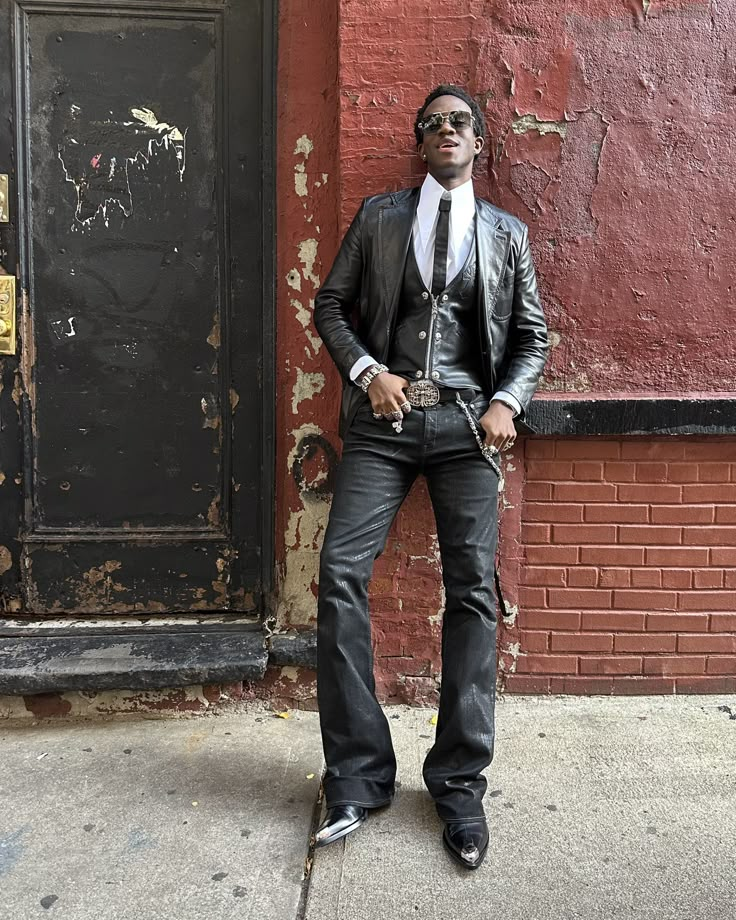

In [38]:
result = get_image_informations("F:\Development\AI\Outfit Song\wisdom_street_suit.jpg")  # <- Replace with your actual image path
print(result)

In [39]:
result

{'image_description': 'A single individual in a sleek black leather ensemble with a white shirt and tie, leaning against a distressed red brick wall beside a worn black door.',
 'people_count': 1,
 'main_objects': ['Person',
  'Leather jacket',
  'Leather vest',
  'White shirt',
  'Black narrow tie',
  'Brick wall',
  'Black metal door'],
 'main_character': 'Person wearing a black leather jacket and vest over a white shirt with a black tie',
 'outfit_characteristics': ['Black leather jacket',
  'Black leather vest',
  'White dress shirt',
  'Black narrow tie',
  'Ornate silver belt buckle with chain',
  'Black flared denim pants',
  'Pointed black leather boots',
  'Dark sunglasses'],
 'background_aesthetics': ['Weathered red brick wall with peeling paint',
  'Worn black metal door',
  'Urban sidewalk'],
 'music_genre': ['Rock & Roll',
  'Glam Rock',
  'Blues Rock',
  'Alternative Rock',
  'Rockabilly']}